In [105]:
import os
os.environ['DEVICE'] = 'cpu'
from pager import PDFModel, WordsModel, RowsModel, PDF2Words, PDF2Rows, ImageModel, PDF2Img
import numpy as np

In [133]:
from pager.page_model.sub_models.dtype import ImageSegment 
import re

class WordGLAMTokenizer:
    def __init__(self):
        self.clusterizer = KMeanClusterizer()
        
    def __call__(self, words_json):
        A = self.get_A(words_json)
        node_features = self.get_node_features(words_json)
        edge_features = self.get_edge_features(A, words_json)
        json_info =  {
            'A': A,
            'node_features': node_features,
            'edge_features': edge_features
        }
        return self.get_tensor_from_graph(json_info)

    def get_A(self, words_json):
        
        neigbors = self.clusterizer.get_index_neighbors_segment([ImageSegment(dict_2p=word_json['segment']) for word_json in words_json])
        A = []
        for i, nodes in enumerate(neigbors):
            for j in nodes:
                if i == j:
                    continue
                A.append((min([i, j]), max([i, j])))
        A1, A2 = [],[]
        
        for a1, a2 in set(A):
            A1.append(a1)
            A2.append(a2)
        index = np.argsort(A1)
        A1_ = [A1[i] for i in index]
        A2_ = [A2[i] for i in index]
    
        return [A1_, A2_]
    
    def get_node_features(self, words_json):
        import numpy as np
        if len(words_json) == 0:
            return [[]]
        word_texts = [w['text'] for w in words_json]
        dot_vec = np.array([[1.0 if dot in r else 0.0 for dot in (".", ",", ";", ":")] for r in word_texts])
        
        list_ind_vec = np.array([self.get_vec_list(w) for w in word_texts])
        super_vec = np.array([self.get_vec_supper(w) for w in word_texts])
        coord_vec = np.array([self.get_vec_coord(w_json) for w_json in words_json])
        heuristics_vec = np.array([self.get_vec_heuristics(w_json) for w_json in words_json])
        nodes_feature = np.concat([coord_vec,  dot_vec, super_vec, list_ind_vec, heuristics_vec], axis=1)
        return nodes_feature.tolist()

    def get_edge_features(self, A, words_json):
        edges_featch = []
        for i, j in zip(A[0], A[1]):
            r1 = ImageSegment(dict_2p= words_json[i]['segment'])
            r2 = ImageSegment(dict_2p= words_json[j]['segment'])
            x1, y1 = r1.get_center()
            x2, y2 = r2.get_center()

            edges_featch.append([r1.get_angle_center(r2), r1.get_min_dist(r2), abs(x1-x2), abs(y1-y2)])
        # print(edges_featch)
        return edges_featch
    
    def get_tensor_from_graph(self, graph):
        import torch
        i = graph["A"]
        v_in = [1 for e in graph["edge_features"]]
        y = graph["edge_features"]
        # for yi in y:
        #     yi[0] = 1.0 if yi[0] > 0.86 else 0.0
        x = graph["node_features"]
        N = len(x)
        
        X = torch.tensor(data=x, dtype=torch.float32)
        Y = torch.tensor(data=y, dtype=torch.float32)
        sp_A = torch.sparse_coo_tensor(indices=i, values=v_in, size=(N, N), dtype=torch.float32)
        
        return {
            "N": N,
            "X": X,
            "Y": Y,
            "sp_A": sp_A,
            "inds": i
        }
    
    def get_vec_heuristics(self, row):
        text = row['text']
        text_size = len(text)
        if text_size == 0:
            return [0, 0]
        seg = ImageSegment(dict_2p=row['segment'])
        m = seg.width/seg.height
        digit_count = sum(char.isdigit() for char in text)
        return [text_size/m, digit_count/text_size]

    def get_vec_supper(self, row_text):
        if row_text.isupper():
            return [1, 0]
        elif row_text and row_text[0].isupper():
            return [0, 1]
        else:
            return [0, 0]
        
    def get_vec_list(self, word_text):
        patterns = [
                r'\b(\d+[.)])\s+',  # 1) 2. 15)
                r'\b([a-zA-Z][.)])\s+',  # a) B.
                r'\b([IVXLCDM]+[.)])\s+',  # XIX. VII)
                r'\[\d+\]',  # [5]
                r'\(\d+\)',  # (3)
                r'(?:^|\s)([•▪▫○◆▶➢✓-])\s+',  # Спецсимволы: • Item, ▪ Subitem
                r'\*{1,}\s+',  # Звездочки: **
                r'\b\d+\.\d+\b',  # Многоуровневые: 1.1, 2.3.4
                r'\b\d+-\w+\)',  # Комбинированные: 1-a), 5-b.
                r'\b(?:Item|Пункт)\s+\d+:\s+',  # Явные указатели: Item 5:
                r'(?:^|\s)\u2022\s+',  # Юникод-символы: •
                r'\[[A-Z]\]',  # Буквы в скобках: [A]
                r'\b\d{2,}\.\s+',  # Номера с ведущими нулями: 01.
                r'#\d+\b',  # Хештег-нумерация: #5
                r'\b\d+\s*[-–—]\s+',  # Тире-разделители: 5 -
                r'\b\d+/\w+\b',  # Слэш-нумерация: 1/a
                r'<\d+>',  # Угловые скобки: <3>
                r'\b[A-Z]\d+\)',  # Буква+число: A1)
                r'\b(?:Step|Шаг)\s+\d+\b',  # Шаги: Step 3
                r'\d+[.)]\s*-\s+',  # Комбинированные с тире: 1). -
                r'\b[А-Яа-я]\s*[).]\s+',  # а) б. кириллица
                r'\b\d+[.:]\d+\)',  # 1:2) вложенность
                r'\d+\s*→\s+',  # 1 → со стрелкой
                r'\b\d+\.?[a-z]\b',  # Буквенные подуровни: 1a
                r'\b[A-Z]+-\d+\b'  # Код-номера: ABC-123
            ]
        flag = False
        for pattern in patterns:
            if bool(re.search(pattern, word_text, flags=re.IGNORECASE)):
                flag = True
                break
        list_mark = 1 if flag else 0
        return [list_mark]

    def get_vec_coord(self, word):
        seg = ImageSegment(dict_2p=word['segment'])
        return [seg.x_top_left, seg.x_bottom_right, seg.width, seg.y_top_left, seg.y_bottom_right, seg.height]

In [134]:
def get_true_edges(token, rows):
    def is_one_row(word_seg_1, word_seg_2, rows):
        
        for i, r in enumerate(rows):
            if r.segment.is_intersection(word_seg_1):
                if r.segment.is_intersection(word_seg_2):
                    return 0
                else:
                    return 1
    A = token['sp_A'].coalesce().indices().tolist()
    true_edges = [is_one_row(words.words[i].segment,words.words[j].segment, rows.rows) for i, j in zip(A[0], A[1])]
    return true_edges

In [135]:
path_pdf = '/home/daniil/dataset/PubLayNet/micro_publaynet_1k/pdfs/train/PMC2570567_00001.pdf'

In [136]:
pdf = PDFModel()
words = WordsModel()
rows = RowsModel()
img = ImageModel()

pdf2words = PDF2Words()
pdf2rows = PDF2Rows()
pdf2img = PDF2Img()

In [137]:
pdf.read_from_file(path_pdf, 'w')
pdf2img.convert(pdf, img)
pdf2words.convert(pdf, words)

pdf.read_from_file(path_pdf, 'r')
pdf2rows.convert(pdf, rows)

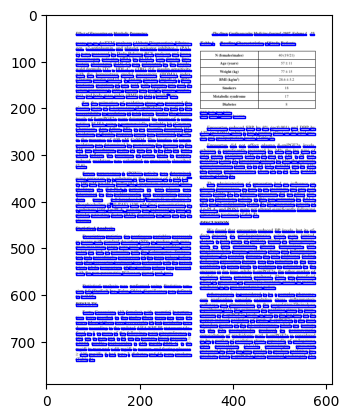

In [138]:
img.show()
for w in words.words:
    w.segment.plot()

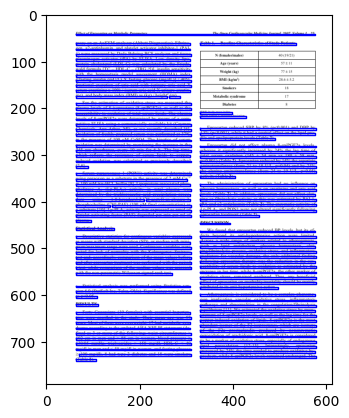

In [139]:
img.show()

H = [r.segment.height for r in rows.rows]
index = []
for i, h in enumerate(H):
    H_ = H[:i] + H[i+1:]
    m = np.mean(H_)
    s = np.std(H_)
    if h < m+3*s and h > m-3*s:
        index.append(i)
rows.rows = [rows.rows[i] for i in index]
for r in rows.rows:
    r.segment.plot()

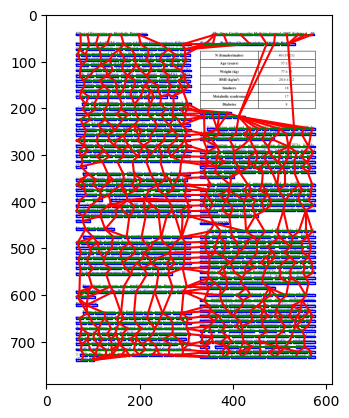

In [141]:
import matplotlib.pyplot as plt

img.show()
for w in words.words:
    w.segment.plot()

tokenizer = WordGLAMTokenizer()
res = tokenizer(words.to_dict()['words'])
true_edges = get_true_edges(res, rows)  
A = res['sp_A'].coalesce().indices().tolist()
for i, j, ind in zip(A[0], A[1], true_edges):
    w1, w2 = words.words[i].segment, words.words[j].segment
    x1, y1 = w1.get_center()
    x2, y2 = w2.get_center()
    
    plt.plot([x1, x2], [y1, y2], 'g' if ind == 0 else 'r')

In [160]:
dataset_path = '/home/daniil/dataset/PubLayNet/micro_publaynet_1k/pdfs/train/'
cash_path = '/home/daniil/dataset/PubLayNet/micro_publaynet_1k/tmp/jsons_rows'

In [161]:
import os
pdfs = os.listdir(dataset_path)

In [163]:
from json import JSONEncoder  
from torch.utils.data import Dataset 
import json
import torch


class EncodeTensor(JSONEncoder, Dataset):  
    def default(self, obj):
        if isinstance(obj, torch.Tensor):  
            return obj.cpu().detach().numpy().tolist()  
        return super(EncodeTensor, self).default(obj)  


pdf = PDFModel()
words = WordsModel()
rows = RowsModel()
img = ImageModel()

pdf2words = PDF2Words()
pdf2rows = PDF2Rows()
pdf2img = PDF2Img()

tokenizer = WordGLAMTokenizer()

os.mkdir(cash_path)

N = len(pdfs)
for i, p in enumerate(pdfs):
    try:
        path_pdf = os.path.join(dataset_path, p)
        
        pdf.read_from_file(path_pdf, 'w')
        pdf2words.convert(pdf, words)
        
        pdf.read_from_file(path_pdf, 'r')
        pdf2rows.convert(pdf, rows)
        
        res = tokenizer(words.to_dict()['words'])
        
        true_edges = get_true_edges(res, rows)
        del res['sp_A']
        res['true_edges'] = true_edges
        
        name_json = os.path.join(cash_path, p+'.json')
        with open(name_json, 'w') as f:  
            json.dump(res, f, cls=EncodeTensor)  
        print(f"{(i+1)/N*100:.2f} %", end='\r')
    except:
        pass

java.io.IOException: Error: Header doesn't contain versioninfo
	at org.apache.pdfbox.pdfparser.PDFParser.parse(PDFParser.java:175)
	at org.apache.pdfbox.pdfparser.PDFParser.parse(PDFParser.java:154)
	at org.apache.pdfbox.Loader.loadPDF(Loader.java:344)
	at org.apache.pdfbox.Loader.loadPDF(Loader.java:317)
	at org.apache.pdfbox.Loader.loadPDF(Loader.java:277)
	at org.apache.pdfbox.Loader.loadPDF(Loader.java:230)
	at DedocTableExtractor.extract(DedocTableExtractor.java:153)
	at DedocTableExtractor.run(DedocTableExtractor.java:102)
	at DedocTableExtractor.main(DedocTableExtractor.java:69)

Expecting value: line 1 column 1 (char 0) <stdout =   >
java.io.IOException: Error: Header doesn't contain versioninfo
	at org.apache.pdfbox.pdfparser.PDFParser.parse(PDFParser.java:175)
	at org.apache.pdfbox.pdfparser.PDFParser.parse(PDFParser.java:154)
	at org.apache.pdfbox.Loader.loadPDF(Loader.java:344)
	at org.apache.pdfbox.Loader.loadPDF(Loader.java:317)
	at org.apache.pdfbox.Loader.loadPDF(Loader

In [43]:
import torch
from torch.nn import Linear, BCELoss, BCEWithLogitsLoss, CrossEntropyLoss, GELU, HuberLoss,ModuleList
from torch.nn.functional import relu
from torch_geometric.nn import BatchNorm, TAGConv
from typing import List


class TagModule(torch.nn.Module):
    def __init__(self, tag):
        super(TagModule, self).__init__()
        if not "k" in tag.keys():
            tag["k"] = 6
        self.linear =Linear(tag['in'], tag['size'])
        self.tag = TAGConv(tag['size'], tag['out'], K=tag['k'])
        self.activation = GELU()
    
    def forward(self, x, edge_index):
        h = self.linear(x)
        h = self.activation(h)
        h = self.tag(h, edge_index)
        h = self.activation(h)
        return h
    

class NodeGLAM(torch.nn.Module):
    def __init__(self,  params):
        super(NodeGLAM, self).__init__()

        self.activation = GELU()
        self.has_bathcnorm = params['batchNormNode'] if 'batchNormNode' in params.keys() else True
        self.batch_norm1 = BatchNorm(params['node_featch'])

        tags = params['Tag']
        if tags[0]['in'] == -1:
            tags[0]['in'] = params['node_featch']
        linear = params['NodeLinear']
        if linear[0] == -1:
            linear[0] = params['node_featch'] + tags[-1]['out']

        classifier_linear = [linear[-1]] + params['NodeLinearClassifier']
        
        self.Tag = ModuleList([TagModule(tag) for tag in tags])
        self.Linear = ModuleList([Linear(linear[i], linear[i+1]) for i in range(len(linear)-1)])
        self.classifiers = ModuleList([Linear(classifier_linear[i], classifier_linear[i+1]) for i in range(len(classifier_linear)-1)])
        self.end_classifier = Linear(classifier_linear[-1], params['NodeClasses'])
        
        self.softmax = torch.nn.Softmax()
    
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        if self.has_bathcnorm:
            x = self.batch_norm1(x)
        h = x
        for layer in self.Tag:
            h = layer(h, edge_index)

        a = torch.cat([x, h], dim=1)
        for layer in self.Linear:
            a = self.activation(layer(a))
        
        cl = a
        for clayer in self.classifiers:
            cl = self.activation(clayer(cl))
        cl = self.softmax(self.end_classifier(cl))
        return a, cl

class EdgeGLAM(torch.nn.Module):
    def __init__(self, params):
        super(EdgeGLAM, self).__init__()
        input_  = 2*params["node_featch"]+2*params["NodeLinear"][-1] + params["edge_featch"]
        # h = params["EdgeLinear"]
        output_ = 1
        self.activation = GELU()
        self.has_bathcnorm = params['batchNormEdge'] if 'batchNormEdge' in params.keys() else True
        self.has_sigmoid = params['sigmoidEdge'] if 'sigmoidEdge' in params.keys() else False
        self.batch_norm2 = BatchNorm(input_, output_)
        
        linear = params['EdgeLinear']
        linear = [input_]+linear
        self.Linear = ModuleList([Linear(linear[i], linear[i+1]) for i in range(len(linear)-1)])
        self.linear_end = Linear(linear[-1], output_)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.has_bathcnorm:
            x = self.batch_norm2(x)
        h = x
        for layer in self.Linear:
            h = self.activation(layer(h))
        h = self.linear_end(h)
        if self.has_sigmoid:
            h = torch.sigmoid(h)
        return torch.squeeze(h, 1)

class CustomLoss(torch.nn.Module):
    def __init__(self, params):
        super(CustomLoss, self).__init__()
                    #BCEWithLogitsLoss
        self.bce = BCEWithLogitsLoss(pos_weight=torch.tensor(params['edge_imbalance']))
        self.ce = CrossEntropyLoss(weight=torch.tensor(params['publaynet_imbalance']))
        self.edge_coef:float = params['edge_coef']
        self.node_coef:float = params['node_coef']

    def forward(self, pred_dict, true_dict):
        # n_pred = pred_dict["node_classes"]
        e_pred = pred_dict["E_pred"]
        # n_true = true_dict["node_classes"]
        e_true = true_dict["true_edges"]
        loss = self.edge_coef*self.bce(e_pred, e_true) # + self.node_coef*self.ce(n_pred, n_true) 
        return loss

class TorchModel(torch.nn.Module):
    
    def __init__(self, params):
        super(TorchModel, self).__init__()
        self.node_emb = NodeGLAM(params)
        self.bin_edge_emb = EdgeGLAM(params)

    def forward(self, data_graph_dict):
        X: torch.Tensor = data_graph_dict["X"] 
        Y: torch.Tensor = data_graph_dict["Y"]
        sp_A: torch.Tensor = data_graph_dict["sp_A"] 
        inds:List[int] = data_graph_dict["inds"]

        Node_embs, Node_classes = self.node_emb(X, sp_A)
        Omega = torch.cat([Node_embs[inds[0]], Node_embs[inds[1]], X[inds[0]], X[inds[1]], Y],dim=1)
        E_pred = self.bin_edge_emb(Omega)
        return {
            "node_classes": Node_classes, 
            "E_pred": E_pred
        }
    


In [44]:
from torch.utils.data import Dataset 
import json
class GLAMDataset(Dataset):
    def __init__(self, json_dir):
        self.json_dir = json_dir
        files  = sorted(os.listdir(self.json_dir))

        if os.path.exists("error_list_file.txt"):
            with open("error_list_file.txt", "r") as f:
                lines = f.readlines()
            error_file = [int(line.split(" ")[0]) for line in lines]
        else:       
            print("TEST OPEN FILE:")
            json_error = []
            key_error = []
            N = len(files)
            for i, file in enumerate(files):
                print(f"{i+1}/{N} ({(i+1)/N*100:.2f} %)" + " "*10, end="\r")
                try:
                    path = os.path.join(self.json_dir, file)
                    with open(path, "r") as f: 
                        j = json.load(f)
                    for k in ["inds", "X", "Y", "N", "true_edges"]:                    
                        if not k in j:
                            key_error.append(i)
                            raise KeyError(f"{k} not in {file}")
                except:
                    json_error.append(i)
            
            if len(key_error) != 0:
                print("KEY ERROR FILES:")
                log("KEY ERROR FILES:")
                for i in key_error:
                    print(files[i])
                    log(files[i])

            if len(json_error) != 0:
                print("JSON ERROR FILES:")
                log("JSON ERROR FILES:")
                for i in json_error:
                    print(files[i])
                    log(files[i])
            error_file = sorted(key_error + json_error, reverse=True)
            with open("error_list_file.txt", "w") as f:
                for i in error_file:
                    f.write(str(i) + " "+ files[i] + '\n')
        for i in error_file:
            del files[i]
        self.files = files
        self.count = len(self.files)

        

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        path = os.path.join(self.json_dir, self.files[idx])
        with open(path, 'r') as f:
            data = json.load(f)
        data['X'] = torch.tensor(data['X'], dtype=torch.float32)
        data['Y'] = torch.tensor(data['Y'], dtype=torch.float32)
        N = data["N"]
        sp_A = torch.sparse_coo_tensor(indices=data['inds'], values=[1 for e in data["Y"]], size=(N, N), dtype=torch.float32)
        data['sp_A'] = sp_A
        data['true_edges'] = torch.tensor([0 if i is None else i for i in data['true_edges']], dtype=torch.float32)
        return data
    
    def __str__(self):
        return f"""DATASET INFO:
count row: {len(self)}
first: {self[0].keys()}
\t A:{np.shape(self[0]["sp_A"])}
\t nodes_feature:{np.shape(self[0]["X"])}
\t edges_feature:{np.shape(self[0]["Y"])}
\t true_edges:{np.shape(self[0]["true_edges"])}
end:{self[-1].keys()}
\t A:{np.shape(self[-1]["sp_A"])}
\t nodes_feature:{np.shape(self[-1]["X"])}
\t edges_feature:{np.shape(self[-1]["Y"])}
\t true_edges:{np.shape(self[-1]["true_edges"])}

"""

In [45]:
dataset = GLAMDataset(cash_path)

In [ ]:
import time
import os
import numpy as np
device = 'cpu'

def validation(model, batch, criterion):     
    return step(model, batch, optimizer=None, criterion=criterion, train=False)

def split_index_train_val(dataset, val_split=0.2, shuffle=True, seed=1234,batch_size=64):
    N = len(dataset)
    count_batchs = int(N*(1-val_split))//batch_size
    count_val_batch = int(N*(val_split))//batch_size
    train_size = count_batchs * batch_size 
    indexs = [i for i in range(N)]
    if shuffle:
        np.random.shuffle(indexs)
    train_indexs = indexs[:train_size]
    val_indexs = indexs[train_size:]
    batchs_train_indexs = [[train_indexs[k*batch_size+i] for i in range(batch_size)] for k in range(count_batchs)]
    batchs_val_indexs = [[val_indexs[k*batch_size+i] for i in range(batch_size)] for k in range(count_val_batch)]
    return batchs_train_indexs, batchs_val_indexs    

def step(model: torch.nn.Module, batch, optimizer, criterion, train=True):
    if train:
        optimizer.zero_grad()
    my_loss_list = []
   
    for j, data_graph_dict in enumerate(batch):
        try:
            if data_graph_dict is None:
                continue
            pred_graph_dict = model(data_graph_dict)
            loss = criterion(pred_graph_dict, data_graph_dict)
            my_loss_list.append(loss.item())
            print(f"{(j+1)/len(batch)*100:.2f} % Batch loss={my_loss_list[-1]:.4f}" + " "*40, end="\r")
        except Exception as e:
            print(e)
            if "Y" in data_graph_dict.keys():
                print(np.array(data_graph_dict['Y']).shape)
            if "X" in data_graph_dict.keys():
                print(np.array(data_graph_dict['X']).shape)
            continue
        if train:  
            loss.backward()
    if train:
        optimizer.step()
    return np.mean(my_loss_list)

def train_model(params, model, dataset, save_frequency=5, start_epoch=0):  
    optimizer = torch.optim.Adam(
    list(model.parameters()),
    lr=params["learning_rate"],
    )
    criterion = CustomLoss(params["loss_params"]) 

    model.to(device)
    criterion.to(device)

    loss_list = []
    start = time.time()
    train_dataset, val_dataset = split_index_train_val(dataset, val_split=0.1, batch_size=params["batch_size"])
    for k in range(start_epoch, params["epochs"]):
        my_loss_list = []
        if k == start_epoch:
            start = time.time()
        for l, batch_indexs in enumerate(train_dataset):
            batch = [dataset[ind] for ind in batch_indexs]
            batch_loss = step(model, batch, optimizer, criterion)
            my_loss_list.append(batch_loss)
            print(f"Batch # {l+1} loss={my_loss_list[-1]:.4f}" + " "*40)
            if (k == start_epoch and l==0):
                print(f"Время обучения batch'а {time.time()-start:.2f} сек")
        train_val = np.mean(my_loss_list)
        loss_list.append(train_val)

        my_loss_list = []
        for l, batch_indexs in enumerate(val_dataset):
            batch = [dataset[ind] for ind in batch_indexs]
            batch_loss = validation(model, batch, criterion)
            my_loss_list.append(batch_loss)
            print(f"Batch # {l+1} loss={my_loss_list[-1]:.4f}" + " "*40)
        validation_val =  np.mean(my_loss_list)
        print("="*10, f"EPOCH #{k+1}","="*10, f"({train_val:.4f}/{validation_val:.4f})")
        if k == start_epoch:
            print(f"Время обучения epoch {time.time()-start:.2f} сек")    
            
        log(f"EPOCH #{k}\t {train_val:.8f} (VAL: {validation_val:.8f})")  
        if (k+1) % save_frequency == 0:
            num = k//save_frequency
            torch.save(model.state_dict(), GLAM_MODEL+f"_tmp_{num}")
    log(f"Время обучения: {time.time()-start:.2f} сек")
    torch.save(model.state_dict(), GLAM_MODEL)


def load_checkpoint(model, path_model,restart_num=None):
    dir_model = os.path.dirname(path_model)
    name_model = os.path.basename(path_model)
    names = [n for n in os.listdir(dir_model) if name_model+'_tmp_' in n]
    if restart_num is None:
        list_num = [int(n.split("_tmp_")[-1]) for n in names]
        if len(list_num) == 0:
            return
        restart_num = max(list_num) 

    checkpoint_path = os.path.join(dir_model, name_model+f"_tmp_{restart_num}")
    model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
    print(checkpoint_path)
    return restart_num

def log(str_):
    with open(LOG_FILE, 'a') as f:
        f.write(str_+'\n')

if __name__ == "__main__":
    is_restart = False
    restart_num = None
    cash_path = '/home/daniil/dataset/PubLayNet/micro_publaynet_1k/tmp/jsons_rows'
    dataset = GLAMDataset(cash_path)
    SAVE_FREQUENCY = 5
    LOG_FILE = 'log.txt'
    GLAM_MODEL = 'word2row_GLAM'
    PARAMS  = {
        "node_featch": 15,
        "edge_featch": 4,
        "epochs": 40,
        "batch_size": 20,
        "learning_rate": 0.01,
        "Tag":[ {'in': -1, 'size': 512, 'out': 256, 'k': 3},
                {'in': 256, 'size': 128, 'out': 64, 'k': 3},
                {'in': 64, 'size': 32, 'out': 16, 'k': 3},
                ],
        "NodeLinear": [-1, 32, 16],
        "NodeLinearClassifier": [8],
        "EdgeLinear": [64, 8],
        "NodeClasses": 5,
        "batchNormNode": True,
        "batchNormEdge": True,
        "seg_k": 0.5,
        "loss_params": {
            "publaynet_imbalance": [0.2, 0.2, 0.2, 0.2, 0.2],
            "edge_imbalance": 0.5,
            "edge_coef": 1,
            "node_coef": 0,
        }
}
    import datetime
    if is_restart:
        log("R E S T A R T ")
    log(datetime.datetime.now().__str__())
    try:
        str_ = dataset.__str__()
        str_ += '\n'.join(f"{key}:\t{val}" for key, val in PARAMS.items())
        print(str_)
        if not is_restart:
            log(str_)
    except:
        print(dataset)

    model:torch.nn.Module = TorchModel(PARAMS)
    if is_restart:
        restart_num = load_checkpoint(model, GLAM_MODEL)
    
    start_epoch = 0 if restart_num is None else (restart_num+1)*SAVE_FREQUENCY
    train_model(PARAMS, model, dataset, save_frequency=SAVE_FREQUENCY, start_epoch=start_epoch)

DATASET INFO:
count row: 1000
first: dict_keys(['N', 'X', 'Y', 'inds', 'true_edges', 'sp_A'])
	 A:torch.Size([631, 631])
	 nodes_feature:torch.Size([631, 15])
	 edges_feature:torch.Size([1348, 4])
	 true_edges:torch.Size([1348])
end:dict_keys(['N', 'X', 'Y', 'inds', 'true_edges', 'sp_A'])
	 A:torch.Size([752, 752])
	 nodes_feature:torch.Size([752, 15])
	 edges_feature:torch.Size([1638, 4])
	 true_edges:torch.Size([1638])

node_featch:	15
edge_featch:	4
epochs:	40
batch_size:	20
learning_rate:	0.01
Tag:	[{'in': -1, 'size': 512, 'out': 256, 'k': 3}, {'in': 256, 'size': 128, 'out': 64, 'k': 3}, {'in': 64, 'size': 32, 'out': 16, 'k': 3}]
NodeLinear:	[-1, 32, 16]
NodeLinearClassifier:	[8]
EdgeLinear:	[64, 8]
NodeClasses:	5
batchNormNode:	True
batchNormEdge:	True
seg_k:	0.5
loss_params:	{'publaynet_imbalance': [0.2, 0.2, 0.2, 0.2, 0.2], 'edge_imbalance': 0.5, 'edge_coef': 1, 'node_coef': 0}
Batch # 1 loss=0.4974                                             
Время обучения batch'а 0.43 сек
Bat